# Chess ML Model

## Import Libraries

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import chess.pgn
import chess.engine
import numpy as np
from collections import Counter
import tensorflow as tf
from keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

## Implementation

### Board → Tensor

In [2]:
def board_to_tensor(board: chess.Board) -> np.ndarray:
    """
    Input: chess.Board
    Output: numpy array of shape (8, 8, 17)
    """
    tensor = np.zeros((8, 8, 17), dtype=np.float32)

    # Piece type mapping for python-chess
    piece_map = {
        chess.PAWN: 0,
        chess.KNIGHT: 1,
        chess.BISHOP: 2,
        chess.ROOK: 3,
        chess.QUEEN: 4,
        chess.KING: 5
    }

    # Iterate through all squares
    for square in chess.SQUARES:
        piece = board.piece_at(square)

        if piece is not None:
            rank = 7 - (square // 8)
            file = square % 8

            piece_type_idx = piece_map[piece.piece_type]

            plane = piece_type_idx
            if piece.color == chess.BLACK:
                plane += 6

            tensor[rank, file, plane] = 1
    
    # Side to move
    tensor[:, :, 12] = 1.0 if board.turn == chess.WHITE else 0.0

    # Planes 13-16: Castling rights
    if board.has_kingside_castling_rights(chess.WHITE):
        tensor[:, :, 13] = 1.0
    
    if board.has_queenside_castling_rights(chess.WHITE):
        tensor[:, :, 14] = 1.0
    
    if board.has_kingside_castling_rights(chess.BLACK):
        tensor[:, :, 15] = 1.0
    
    if board.has_queenside_castling_rights(chess.BLACK):
        tensor[:, :, 16] = 1.0

    return tensor

### Centipawn Score

In [3]:
def score_to_cp(score):
    """
    Convert Stockfish score to centipawn float in [-10, 10]
    """
    score_obj = score.white()
    if score_obj.is_mate():
        mate_in = score_obj.mate()
        return 1.0 if mate_in > 0 else -1.0

    cp = score.white().score()
    if cp is None:
        return 0.0

    # scale and clamp. Use /1000 for stability (range [-10,10] -> clamp to [-1,1])
    val = cp / 1000.0
    return float(max(-1.0, min(1.0, val)))

### Position → Training Sample

In [4]:
def create_dataset_from_pgn(pgn_file, MAX_POSITIONS=200):
    '''
    Create dataset from PGN file.
    Return:
        List of (tensor, label) tuples
    '''
    engine = chess.engine.SimpleEngine.popen_uci("/usr/games/stockfish")
    dataset = []

    SKIP_PLIES = 8
    STRIDE = 3
    ply = 0

    with open(pgn_file, "r", encoding="utf-8") as f:
        while len(dataset) < MAX_POSITIONS:
            game = chess.pgn.read_game(f)
            if game is None:
                break       # Stop as no more games

            board = game.board()
            ply += 1

            if ply < SKIP_PLIES:
                continue

            if ply % STRIDE != 0:
                continue
            
            for move in game.mainline_moves():
                board.push(move)
                
                info = engine.analyse(board, chess.engine.Limit(depth=12))

                if "score" in info:
                    tensor = board_to_tensor(board)
                    cp_value = score_to_cp(info["score"])
                    dataset.append((tensor, cp_value))

                if len(dataset) >= MAX_POSITIONS:
                    break

    engine.quit()
    return dataset

## Load PGN File
PGN means Portable Games Notation. On more and more games a PGN files becomes more solid.

In [5]:
pgn_file = "hastm2526.pgn"

dataset = create_dataset_from_pgn(pgn_file, 1000)

print(len(dataset))
print(dataset[0][0].shape)

labels = [label for _, label in dataset]
print(Counter(labels))

1000
(8, 8, 17)
Counter({0.032: 16, 0.025: 16, 0.039: 15, 0.028: 14, 0.035: 14, 0.0: 11, 0.04: 10, 0.037: 10, -0.039: 9, 0.021: 9, 0.031: 9, 0.046: 9, 0.06: 8, 0.027: 8, 0.026: 8, 0.023: 8, 0.038: 8, 0.015: 7, 0.013: 7, 0.03: 7, 0.01: 7, 0.017: 7, 0.029: 7, -1.0: 7, 0.062: 7, 0.053: 7, 0.055: 7, 0.036: 7, 0.02: 7, 0.034: 7, 0.014: 7, 0.019: 6, -0.041: 6, -0.034: 6, -0.042: 6, 0.048: 6, 0.082: 6, 0.059: 6, 0.051: 6, 0.007: 5, -0.032: 5, -0.04: 5, -0.043: 5, 0.047: 5, 0.071: 5, 0.049: 5, 0.052: 5, 0.044: 5, 0.012: 5, 0.011: 5, 0.033: 5, -0.003: 5, 0.043: 5, -0.036: 5, 0.067: 5, -0.16: 5, -0.018: 4, -0.014: 4, -0.044: 4, -0.037: 4, -0.028: 4, -0.015: 4, -0.024: 4, -0.055: 4, 0.018: 4, 0.056: 4, 0.016: 4, 0.069: 4, 0.022: 4, 0.058: 4, -0.215: 4, 0.042: 4, -0.002: 4, -0.02: 3, -0.022: 3, -0.021: 3, -0.057: 3, -0.019: 3, -0.007: 3, -0.035: 3, -0.046: 3, -0.025: 3, -0.058: 3, -0.016: 3, -0.011: 3, -0.006: 3, -0.052: 3, -0.094: 3, -0.432: 3, 0.008: 3, 0.005: 3, 0.098: 3, 0.131: 3, 0.216: 3, 0.

## Data Preparation

### Convert dataset

In [6]:
X = np.array([tensor for tensor, _ in dataset])
y = np.array([label for _, label in dataset])

print(X.shape)
print(y.shape)
print(y[:10])
print(y.min(), y.max())

(1000, 8, 8, 17)
(1000,)
[0.032 0.068 0.025 0.06  0.027 0.019 0.028 0.015 0.013 0.007]
-1.0 1.0


### Split dataset

In [7]:
y_binned = np.digitize(y, bins=[-0.5, 0.0, 0.5]) - 1

X_train, X_val, y_train, y_val = train_test_split(
    X, y_binned,
    test_size=0.2,
    random_state=42,
    stratify=y_binned
)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(800, 8, 8, 17) (800,)
(200, 8, 8, 17) (200,)


### Class Weights

In [8]:
label_counts = Counter(y_train)
print(label_counts)

total = len(y_train)
num_classes = 3

class_weight = {
    cls: total / (num_classes * count)
    for cls, count in label_counts.items()
}

print(class_weight)

Counter({np.int64(1): 450, np.int64(0): 311, np.int64(-1): 30, np.int64(2): 9})
{np.int64(1): 0.5925925925925926, np.int64(0): 0.857449088960343, np.int64(-1): 8.88888888888889, np.int64(2): 29.62962962962963}


## Model

In [9]:
model = models.Sequential([
    layers.Input(shape=(8, 8, 17,)),
    layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="tanh")
])

model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=["accuracy"]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 8, 8, 32)       │         4,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 557,217 (2.13 MB)

 Trainable params: 557,217 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=16,
    class_weight=class_weight,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6025 - loss: 1.8314 - val_accuracy: 0.5950 - val_loss: 0.4037
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6488 - loss: 0.8948 - val_accuracy: 0.6150 - val_loss: 0.2898
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7763 - loss: 0.5268 - val_accuracy: 0.8800 - val_loss: 0.1138
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8275 - loss: 0.4736 - val_accuracy: 0.8550 - val_loss: 0.1282
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8625 - loss: 0.4374 - val_accuracy: 0.8950 - val_loss: 0.1041
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8863 - loss: 0.3983 - val_accuracy: 0.8950 - val_loss: 0.0817
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9013 - loss: 0.3859 - val_accuracy: 0.9050 - val_loss: 0.0768
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9137 - loss: 0.3801 - val_accuracy: 0.9100 - val_loss

## Test

In [11]:
# Predict on training data (for now)
y_val_pred_raw = model.predict(X_val).flatten()
y_val_pred = np.digitize(y_val_pred_raw, bins=[-0.33, 0.33]) - 1

print("Predicted labels:", y_val_pred[:10])
print("True labels     :", y_val[:10])

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Predicted labels: [ 1  1  1 -1 -1  0 -1 -1  1  1]
True labels     : [ 1  1  1  0 -1  0  0  0  0  0]


## Confusion Matrix

In [12]:
cm_val = confusion_matrix(y_val, y_val_pred)
print(cm_val)

[[  6   1   0   0]
 [  9  58  11   0]
 [  0   0 113   0]
 [  0   0   2   0]]


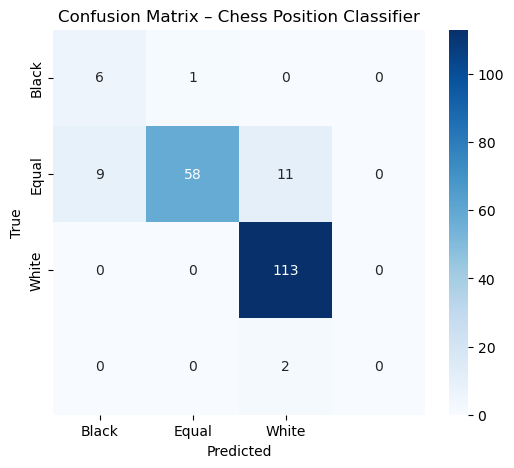

In [13]:
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm_val,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=["Black", "Equal", "White"],
    yticklabels=["Black", "Equal", "White"]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – Chess Position Classifier")
plt.show()

## Save the Model

In [14]:
model.save("models/chess_cnn_evaluator.keras")